# Eurovision 2022 (Draft Notebook)


## Potential Research Questions

1. Are Jury Voters less affected by Cultural Influences in Eurovision ?
2. [Needs to be Formulated Well] Does a sympathy-wave effect for Ukraine exist in 2022 Eurovision results?  How can we account for that?


## Plan

### 1. Pre-Analysis or Exploratory Data Analysis

Worth doing again, with newer data.

1. Basically, redo figure 7 from the paper with the newest data

## 2. Agent-Based Models

1. Null Model
2. Model 1
3. Cultural Affinity Model
   a. Cultural Affinity Model part 2


## 3. Find Best Fit

1. Kolmogorov-Smirnov test
2. Hypothesis: Simulated and Empirical FoF come from the same distribution.
    3. This was rejected in the original paper
    
    
### Further Work
1. Consider doing section 5
2. Ambitious: Section 6


Suggestion: Focus on the ABMs as opposed to fully recreating the full paper (K-S tests etc.) 
Also try various things:  subsets of networks.  what happens if you take away a node etc etc.  Give extra weight to Ukraine itself?

In [98]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Model, Agent
from mesa.time import RandomActivation
#import pyvis.network as pyvisnetwork
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector


from scipy.stats import rankdata
from scipy.stats import ks_2samp

# 1. Exploratory Data Analysis

First, we load the data for the various years and then visualize the network for a given year

In [99]:
#df = pd.read_excel('https://query.data.world/s/cuokq5sbbqlogvjrdwdeacvp367xnq')
df = pd.read_csv("data/dataworld.csv")
df

,Unnamed: 0,Unnamed: 0.1,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


In [100]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    "(semi-) final": "semi_or_final",
    "Jury or Televoting": "jury_or_televoting",
    "From country": "from",
    "To country": "to",
    "Points": "points"
}, inplace=True)

In [101]:
df_finals = df[df["semi_or_final"] == 'f']
df_finals_televoting = df_finals[df_finals["jury_or_televoting"] == "T"]
df_finals_jury = df_finals[df_finals["jury_or_televoting"] == "J"]


display(df_finals_televoting)
display(df_finals_jury)

,Unnamed: 0,Unnamed: 0.1,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
36352,36352,36352,2016,f,2016f,T,Albania,Armenia,2,NaN
36353,36353,36353,2016,f,2016f,T,Albania,Australia,12,NaN
36354,36354,36354,2016,f,2016f,T,Albania,Austria,0,NaN
36355,36355,36355,2016,f,2016f,T,Albania,Azerbaijan,0,NaN
36356,36356,36356,2016,f,2016f,T,Albania,Belgium,0,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


,Unnamed: 0,Unnamed: 0.1,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56283,56283,56283,2022,f,2022f,J,United Kingdom,Serbia,1,NaN
56284,56284,56284,2022,f,2022f,J,United Kingdom,Spain,10,NaN
56285,56285,56285,2022,f,2022f,J,United Kingdom,Sweden,12,NaN
56286,56286,56286,2022,f,2022f,J,United Kingdom,Switzerland,2,NaN


Let's visualize!

# Agent Based Modelling

In [102]:
SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
alpha = 0.1

In [103]:
def calc_All_FoF(df, from_country, points_column = "points", FoF_column = "FoF"):
    Voter_selector = df["from"] == from_country

    voting_countries_2022 = df["from"].unique()


    N = len(voting_countries_2022)
    
    for to_country in df["to"].unique():
        Candidate_selector = df["to"] == to_country

        final_score = sum(df.loc[Candidate_selector, points_column])

        points = df.loc[Voter_selector & Candidate_selector, points_column]

        df.loc[Voter_selector & Candidate_selector, FoF_column ] =  ( points / 12 ) - ( ( final_score - points )/( 12*(N-2) ) )

## Null Model

In this null model, countries freely vote for other countries.  The only restriction is that they can assign only a fixed amount of points

In [104]:
class NullVotingAgent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Null Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        self.df = df
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        #print(f"Country {self.unique_id} is now voting")
        
        country_row_selector = self.df["from"] == self.unique_id

        fit = np.random.uniform(0, 1, size=len( self.df[country_row_selector] ))

        points_given = 58 * (fit/sum(fit))
        
        #print(f"{voting_country=}, {points_given=}")
        self.df.loc[country_row_selector, "null_model_points"] += points_given

In [105]:
def get_null_model_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["null_model_FoF"]
    
    return ks_2samp(data1, data2)

class NullVotingModel(Model):
    
    def __init__(self, jury_or_televoting, year):
        '''
        Create a new NullVotingModel model.

         Args:
            jury_or_televoting: a string with values  
                * J: Jury
                * T: Televoting
            year: year of competition
        '''
        
        super().__init__()
        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()

        self.df = df_finals_televoting_year
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_null_model_ks}
        )
        
        self.schedule = RandomActivation(self)
        
        
        self.df["null_model_points"] = 0
        self.df["FoF"] = 0
        self.df["null_model_FoF"] = 0

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            the_agent = NullVotingAgent(voting_country, self, self.df)
            self.schedule.add(the_agent)
            

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'null_model_points', "null_model_FoF")
            
        self.datacollector.collect(self)

## Model1 ABM
This model also gives points at random, but follows the rules of the contest

In [106]:
class Model1Agent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        self.df = df
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        country_row_selector = self.df["from"] == self.unique_id

        fit = pd.Series( np.random.uniform(0, 1, size=len(self.df[country_row_selector])) )
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        #print(f"{rank=}, {voting_country=}, {type(points_given)=}")
        self.df.loc[country_row_selector, "model1_points"] += points_given.to_numpy()

In [107]:
def get_model1_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["model1_FoF"]
    
    return ks_2samp(data1, data2)


class Model1Model(Model):
    
    def __init__(self, jury_or_televoting, year):
        '''
        Create a new NullVotingModel model.

         Args:
            jury_or_televoting: a string with values  
                * J: Jury
                * T: Televoting
            year: year of competition
        '''
        
        super().__init__()
        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()

        self.df = df_finals_televoting_year
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_model1_ks}
        )
        
        self.df["model1_points"] = 0
        
        self.schedule = RandomActivation(self)
        

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            a = Model1Agent(voting_country, self, self.df)
            self.schedule.add(a)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'model1_points', "model1_FoF")
            
        self.datacollector.collect(self)

## Affinity Model

In [108]:
class AffinityModelAgent(Agent):
    
    def __init__(self, unique_id, model, df, alpha, cultural_network):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        self.df = df
        self.cultural_network = cultural_network
        self.alpha = alpha
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        country_row_selector = self.df["from"] == self.unique_id
        
        def affinity_fit(row):
            '''
                row: a dataframe row
            '''
            q = float(self.df["relative_score"].sample(1))

            from_country = row['from']
            to_country = row['to']


            network_part = nx.get_edge_attributes(self.cultural_network, "weight")[(from_country, to_country)]

            the_fit = self.alpha * q + network_part * (1 - self.alpha)

            return the_fit

        
        country_df = self.df[country_row_selector]

        fit = country_df.apply(
            lambda row: affinity_fit(row), axis=1
        )
        #print(f"{unique_id=}, {fit=}")
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        self.df.loc[country_row_selector, "affinity_model_points"] += points_given.to_numpy()


In [109]:
def get_affinity_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["affinity_model_FoF"]
    
    return ks_2samp(data1, data2)


class AffinityModel(Model):
    
    def __init__(self,jury_or_televoting, year, mu, sigma, alpha):
        '''
        Create a new NullVotingModel model.

         Args:
        '''
        
        super().__init__()
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_affinity_ks}
        )

        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()
        self.df = df_finals_televoting_year
        
        self.df["affinity_model_points"] = 0
        
        self.df["relative_score"] = self.df["points"]/sum(self.df["points"])
        
        
        self.cultural_network = nx.from_pandas_edgelist(
            self.df,
            source="from",
            target="to",
            create_using=nx.DiGraph()
        )

        self.mu = mu
        self.sigma = sigma
        self.alpha = alpha

        dict_weight = {}
        for edge in self.cultural_network.edges():
            sampled_weight = np.random.normal(mu, sigma)
            dict_weight[edge] = sampled_weight
        nx.set_edge_attributes(self.cultural_network, values = dict_weight, name = 'weight')
        
        

        voting_countries = self.df["from"].unique()
        
        self.schedule = RandomActivation(self)

        for voting_country in voting_countries:
            a = AffinityModelAgent(voting_country, self, self.df, self.alpha, self.cultural_network)
            self.schedule.add(a)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'affinity_model_points', "affinity_model_FoF")
            
        self.datacollector.collect(self)

# 3. Run the ABMs in a batch for various years



# 4. Friend-Or-Foe for the ABMS

Now that we have Various models and also empirical data, we can calculate the Friend-or-Foe coefficients for each of them

## Batch Run

In [110]:
params_null = {
    "jury_or_televoting": "T",
    "year": [2021, 2022]    # 2020 Contest was cancelled due to COVID-19
}

In [111]:
from mesa.batchrunner import batch_run

#results = batch_run(
#    NullVotingModel,
#    parameters=params_null,
#    iterations=10,
#    max_steps=1,
#    number_processes=None,
#    data_collection_period=-1,
#    display_progress=True,
#)

In [112]:
#res_null = pd.DataFrame(results)
#res_null.to_csv("res_null.csv")

In [113]:
res_null = pd.read_csv("res_null.csv")
display(res_null)

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,ks_statistic,ks_pval
0,0,0,0,1,T,2021,0.246964,7.443150e-27
1,1,1,0,1,T,2022,0.189744,9.360958e-16
2,2,2,0,1,J,2022,0.210256,2.826301e-19
3,3,3,0,1,J,2021,0.218623,4.330497e-21
4,4,4,0,1,T,2016,0.236398,1.567102e-26
5,5,5,0,1,T,2019,0.226488,7.876122e-24
6,6,6,0,1,T,2017,0.276557,3.705405e-37
7,7,7,1,1,T,2016,0.242964,5.124098e-28
8,8,8,1,1,T,2019,0.225528,1.247297e-23
9,9,9,1,1,T,2017,0.247253,1.044989e-29


In [114]:
# Televotes
df_null_2016_T = res_null[(res_null["year"] == 2016) & (res_null["jury_or_televoting"] == "T")]
df_null_2017_T = res_null[(res_null["year"] == 2017) & (res_null["jury_or_televoting"] == "T")]
df_null_2018_T = res_null[(res_null["year"] == 2018) & (res_null["jury_or_televoting"] == "T")]
df_null_2019_T = res_null[(res_null["year"] == 2019) & (res_null["jury_or_televoting"] == "T")]

df_null_2021_T = res_null[(res_null["year"] == 2021) & (res_null["jury_or_televoting"] == "T")]
df_null_2022_T = res_null[(res_null["year"] == 2021) & (res_null["jury_or_televoting"] == "T")]


# Jury Votes
df_null_2016_J = res_null[(res_null["year"] == 2016) & (res_null["jury_or_televoting"] == "J")]
df_null_2017_J = res_null[(res_null["year"] == 2017) & (res_null["jury_or_televoting"] == "J")]
df_null_2018_J = res_null[(res_null["year"] == 2018) & (res_null["jury_or_televoting"] == "J")]
df_null_2019_J = res_null[(res_null["year"] == 2019) & (res_null["jury_or_televoting"] == "J")]

df_null_2021_J = res_null[(res_null["year"] == 2021) & (res_null["jury_or_televoting"] == "J")]
df_null_2022_J = res_null[(res_null["year"] == 2021) & (res_null["jury_or_televoting"] == "J")]


# ks-statistics Televotes

kses_2016_T = df_null_2016_T["ks_statistic"]
kses_2017_T = df_null_2017_T["ks_statistic"]
kses_2018_T = df_null_2018_T["ks_statistic"]
kses_2019_T = df_null_2019_T["ks_statistic"]

kses_2021_T = df_null_2021_T["ks_statistic"]
kses_2022_T = df_null_2022_T["ks_statistic"]

# ks-statistics Jury Votes

kses_2016_J = df_null_2016_J["ks_statistic"]
kses_2017_J = df_null_2017_J["ks_statistic"]
kses_2018_J = df_null_2018_J["ks_statistic"]
kses_2019_J = df_null_2019_J["ks_statistic"]

kses_2021_J = df_null_2021_J["ks_statistic"]
kses_2022_J = df_null_2022_J["ks_statistic"]

In [115]:
df_null_2016_T.loc[kses_2016_T.idxmin()]

Unnamed: 0                  38
RunId                       38
iteration                    3
Step                         1
jury_or_televoting           T
year                      2016
ks_statistic          0.222326
ks_pval                    0.0
Name: 38, dtype: object

In [116]:
df_null_2016_J.loc[kses_2016_J.idxmin()]

Unnamed: 0                  23
RunId                       23
iteration                    1
Step                         1
jury_or_televoting           J
year                      2016
ks_statistic          0.228893
ks_pval                    0.0
Name: 23, dtype: object

In [117]:
df_null_2017_T.loc[kses_2017_T.idxmin()]

Unnamed: 0                   9
RunId                        9
iteration                    1
Step                         1
jury_or_televoting           T
year                      2017
ks_statistic          0.247253
ks_pval                    0.0
Name: 9, dtype: object

In [118]:
df_null_2017_J.loc[kses_2017_J.idxmin()]

Unnamed: 0                  46
RunId                       46
iteration                    3
Step                         1
jury_or_televoting           J
year                      2017
ks_statistic          0.186813
ks_pval                    0.0
Name: 46, dtype: object

In [119]:
df_null_2018_T.loc[kses_2018_T.idxmin()]

Unnamed: 0                  41
RunId                       41
iteration                    3
Step                         1
jury_or_televoting           T
year                      2018
ks_statistic          0.224508
ks_pval                    0.0
Name: 41, dtype: object

In [120]:
df_null_2018_J.loc[kses_2018_J.idxmin()]

Unnamed: 0                  34
RunId                       34
iteration                    2
Step                         1
jury_or_televoting           J
year                      2018
ks_statistic          0.205725
ks_pval                    0.0
Name: 34, dtype: object

In [121]:
df_null_2019_T.loc[kses_2019_T.idxmin()]

Unnamed: 0                 39
RunId                      39
iteration                   3
Step                        1
jury_or_televoting          T
year                     2019
ks_statistic          0.21785
ks_pval                   0.0
Name: 39, dtype: object

In [122]:
df_null_2019_J.loc[kses_2019_J.idxmin()]

Unnamed: 0                  22
RunId                       22
iteration                    1
Step                         1
jury_or_televoting           J
year                      2019
ks_statistic          0.178503
ks_pval                    0.0
Name: 22, dtype: object

In [123]:
df_null_2021_T.loc[kses_2021_T.idxmin()]

Unnamed: 0                  48
RunId                       48
iteration                    4
Step                         1
jury_or_televoting           T
year                      2021
ks_statistic          0.224696
ks_pval                    0.0
Name: 48, dtype: object

In [124]:
df_null_2021_J.loc[kses_2021_J.idxmin()]

Unnamed: 0                  33
RunId                       33
iteration                    2
Step                         1
jury_or_televoting           J
year                      2021
ks_statistic          0.196356
ks_pval                    0.0
Name: 33, dtype: object

In [125]:
df_null_2022_T.loc[kses_2022_T.idxmin()]

Unnamed: 0                  48
RunId                       48
iteration                    4
Step                         1
jury_or_televoting           T
year                      2021
ks_statistic          0.224696
ks_pval                    0.0
Name: 48, dtype: object

In [126]:
df_null_2022_J.loc[kses_2022_J.idxmin()]

Unnamed: 0                  33
RunId                       33
iteration                    2
Step                         1
jury_or_televoting           J
year                      2021
ks_statistic          0.196356
ks_pval                    0.0
Name: 33, dtype: object

In [127]:
params_model1 = {
    "jury_or_televoting": "T",
    "year": [2021, 2022]    # 2020 Contest was cancelled due to COVID-19
}

In [128]:
from mesa.batchrunner import batch_run

#results = batch_run(
#    Model1Model,
#    parameters=params_model1,
#    iterations=10,
#    max_steps=1,
#    number_processes=None,
#    data_collection_period=-1,
#    display_progress=True,
#)

In [129]:
#res_model1 = pd.DataFrame(results)
#res_model1.to_csv("res_model1.csv")

In [130]:
res_model1 = pd.read_csv("res_model1.csv")
display(res_model1)

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,ks_statistic,ks_pval
0,0,0,0,1,J,2022,0.308718,1.993156e-41
1,1,1,0,1,T,2022,0.334359,1.159295e-48
2,2,2,0,1,T,2021,0.379555,8.778020e-64
3,3,3,0,1,J,2021,0.339069,1.012237e-50
4,4,4,0,1,T,2019,0.370441,5.353011e-64
5,5,5,0,1,J,2019,0.334933,3.689909e-52
6,6,6,0,1,T,2016,0.364916,1.722770e-63
7,7,7,1,1,T,2019,0.350288,4.049945e-57
8,8,8,1,1,T,2016,0.343340,4.242172e-56
9,9,9,0,1,J,2017,0.368132,3.351347e-66


In [131]:
# Televotes
df_model1_2016_T = res_model1[(res_model1["year"] == 2016) & (res_model1["jury_or_televoting"] == "T")]
df_model1_2017_T = res_model1[(res_model1["year"] == 2017) & (res_model1["jury_or_televoting"] == "T")]
df_model1_2018_T = res_model1[(res_model1["year"] == 2018) & (res_model1["jury_or_televoting"] == "T")]
df_model1_2019_T = res_model1[(res_model1["year"] == 2019) & (res_model1["jury_or_televoting"] == "T")]

df_model1_2021_T = res_model1[(res_model1["year"] == 2021) & (res_model1["jury_or_televoting"] == "T")]
df_model1_2022_T = res_model1[(res_model1["year"] == 2022) & (res_model1["jury_or_televoting"] == "T")]

# Jury Votes
df_model1_2016_J = res_model1[(res_model1["year"] == 2016) & (res_model1["jury_or_televoting"] == "J")]
df_model1_2017_J = res_model1[(res_model1["year"] == 2017) & (res_model1["jury_or_televoting"] == "J")]
df_model1_2018_J = res_model1[(res_model1["year"] == 2018) & (res_model1["jury_or_televoting"] == "J")]
df_model1_2019_J = res_model1[(res_model1["year"] == 2019) & (res_model1["jury_or_televoting"] == "J")]

df_model1_2021_J = res_model1[(res_model1["year"] == 2021) & (res_model1["jury_or_televoting"] == "J")]
df_model1_2022_J = res_model1[(res_model1["year"] == 2022) & (res_model1["jury_or_televoting"] == "J")]


# ks-statistics Televotes

kses_2016_T = df_model1_2016_T["ks_statistic"]
kses_2017_T = df_model1_2017_T["ks_statistic"]
kses_2018_T = df_model1_2018_T["ks_statistic"]
kses_2019_T = df_model1_2019_T["ks_statistic"]

kses_2021_T = df_model1_2021_T["ks_statistic"]
kses_2022_T = df_model1_2022_T["ks_statistic"]

# ks-statistics Jury Votes

kses_2016_J = df_model1_2016_J["ks_statistic"]
kses_2017_J = df_model1_2017_J["ks_statistic"]
kses_2018_J = df_model1_2018_J["ks_statistic"]
kses_2019_J = df_model1_2019_J["ks_statistic"]

kses_2021_J = df_model1_2021_J["ks_statistic"]
kses_2022_J = df_model1_2022_J["ks_statistic"]

In [132]:
df_model1_2016_T.loc[kses_2016_T.idxmin()]

Unnamed: 0                  8
RunId                       8
iteration                   1
Step                        1
jury_or_televoting          T
year                     2016
ks_statistic          0.34334
ks_pval                   0.0
Name: 8, dtype: object

In [133]:
df_model1_2016_J.loc[kses_2016_J.idxmin()]

Unnamed: 0                  10
RunId                       10
iteration                    0
Step                         1
jury_or_televoting           J
year                      2016
ks_statistic          0.314259
ks_pval                    0.0
Name: 10, dtype: object

In [134]:
df_model1_2017_T.loc[kses_2017_T.idxmin()]

Unnamed: 0                  27
RunId                       27
iteration                    2
Step                         1
jury_or_televoting           T
year                      2017
ks_statistic          0.369048
ks_pval                    0.0
Name: 27, dtype: object

In [135]:
df_model1_2017_J.loc[kses_2017_J.idxmin()]

Unnamed: 0                  31
RunId                       31
iteration                    2
Step                         1
jury_or_televoting           J
year                      2017
ks_statistic          0.342491
ks_pval                    0.0
Name: 31, dtype: object

In [136]:
df_model1_2018_T.loc[kses_2018_T.idxmin()]

Unnamed: 0                 49
RunId                      49
iteration                   4
Step                        1
jury_or_televoting          T
year                     2018
ks_statistic          0.36136
ks_pval                   0.0
Name: 49, dtype: object

In [137]:
df_model1_2018_J.loc[kses_2018_J.idxmin()]

Unnamed: 0                  35
RunId                       35
iteration                    2
Step                         1
jury_or_televoting           J
year                      2018
ks_statistic          0.325581
ks_pval                    0.0
Name: 35, dtype: object

In [138]:
df_model1_2019_T.loc[kses_2019_T.idxmin()]

Unnamed: 0                   7
RunId                        7
iteration                    1
Step                         1
jury_or_televoting           T
year                      2019
ks_statistic          0.350288
ks_pval                    0.0
Name: 7, dtype: object

In [139]:
df_model1_2019_J.loc[kses_2019_J.idxmin()]

Unnamed: 0                  57
RunId                       57
iteration                    4
Step                         1
jury_or_televoting           J
year                      2019
ks_statistic          0.331094
ks_pval                    0.0
Name: 57, dtype: object

In [140]:
df_model1_2021_T.loc[kses_2021_T.idxmin()]

Unnamed: 0                  37
RunId                       37
iteration                    3
Step                         1
jury_or_televoting           T
year                      2021
ks_statistic          0.375506
ks_pval                    0.0
Name: 37, dtype: object

In [141]:
df_model1_2021_J.loc[kses_2021_J.idxmin()]

Unnamed: 0                   3
RunId                        3
iteration                    0
Step                         1
jury_or_televoting           J
year                      2021
ks_statistic          0.339069
ks_pval                    0.0
Name: 3, dtype: object

In [142]:
df_model1_2022_T.loc[kses_2022_T.idxmin()]

Unnamed: 0                   1
RunId                        1
iteration                    0
Step                         1
jury_or_televoting           T
year                      2022
ks_statistic          0.334359
ks_pval                    0.0
Name: 1, dtype: object

In [143]:
df_model1_2022_J.loc[kses_2022_J.idxmin()]

Unnamed: 0                  41
RunId                       41
iteration                    3
Step                         1
jury_or_televoting           J
year                      2022
ks_statistic          0.307692
ks_pval                    0.0
Name: 41, dtype: object

In [144]:
params_affinity = {
    "jury_or_televoting": "T",
    "year": [2021, 2022],    # 2020 Contest was cancelled due to COVID-19
    "mu": np.linspace(-0.1, 0.1, 21),
    "sigma": np.linspace(0, 0.1, 21),
    "alpha": np.linspace(0, 0.5, 3)
} 

In [145]:
from mesa.batchrunner import batch_run
#
#results = batch_run(
#    AffinityModel,
#    parameters=params_affinity,
#    iterations=10,
#    max_steps=1,
#    number_processes=None,
#    data_collection_period=-1,
#    display_progress=True,
#)

In [146]:
#res_affinity = pd.DataFrame(results)
#res_affinity.to_csv("res_affinity.csv")

In [147]:
res_affinity = pd.read_csv("res_affinity.csv")

In [148]:
display(res_affinity)

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,mu,sigma,alpha,ks_statistic,ks_pval
0,0,0,0,1,T,2016,-0.1,0.10,0.50,0.528143,2.768433e-136
1,1,1,0,1,T,2016,-0.1,0.00,0.25,0.392120,1.611083e-73
2,2,2,0,1,T,2016,0.0,0.00,0.00,0.694184,4.796560e-246
3,3,3,0,1,T,2016,-0.1,0.00,0.00,0.694184,4.796560e-246
4,4,4,0,1,T,2016,-0.1,0.05,0.00,0.521576,9.661474e-133
...,...,...,...,...,...,...,...,...,...,...,...
1615,1615,1615,4,1,J,2022,0.1,0.05,0.50,0.494359,1.537304e-108
1616,1616,1616,4,1,J,2022,0.1,0.05,0.00,0.508718,3.062547e-115
1617,1617,1617,4,1,J,2022,0.1,0.10,0.00,0.480000,4.534451e-102
1618,1618,1618,4,1,J,2022,0.1,0.10,0.50,0.495385,5.198155e-109


In [149]:
#Televotes
df_affinity_2016_T = res_affinity[(res_affinity["year"] == 2016) & (res_affinity["jury_or_televoting"] == "T")]
df_affinity_2017_T = res_affinity[(res_affinity["year"] == 2017) & (res_affinity["jury_or_televoting"] == "T")]
df_affinity_2018_T = res_affinity[(res_affinity["year"] == 2018) & (res_affinity["jury_or_televoting"] == "T")]
df_affinity_2019_T = res_affinity[(res_affinity["year"] == 2019) & (res_affinity["jury_or_televoting"] == "T")]

df_affinity_2021_T = res_affinity[(res_affinity["year"] == 2021) & (res_affinity["jury_or_televoting"] == "T")]
df_affinity_2022_T = res_affinity[(res_affinity["year"] == 2022) & (res_affinity["jury_or_televoting"] == "T")]

# Jury Votes
df_affinity_2016_J = res_affinity[(res_affinity["year"] == 2016) & (res_affinity["jury_or_televoting"] == "J")]
df_affinity_2017_J = res_affinity[(res_affinity["year"] == 2017) & (res_affinity["jury_or_televoting"] == "J")]
df_affinity_2018_J = res_affinity[(res_affinity["year"] == 2018) & (res_affinity["jury_or_televoting"] == "J")]
df_affinity_2019_J = res_affinity[(res_affinity["year"] == 2019) & (res_affinity["jury_or_televoting"] == "J")]

df_affinity_2021_J = res_affinity[(res_affinity["year"] == 2021) & (res_affinity["jury_or_televoting"] == "J")]
df_affinity_2022_J = res_affinity[(res_affinity["year"] == 2022) & (res_affinity["jury_or_televoting"] == "J")]


# ks-statistics Televotes

kses_2016_T = df_affinity_2016_T["ks_statistic"]
kses_2017_T = df_affinity_2017_T["ks_statistic"]
kses_2018_T = df_affinity_2018_T["ks_statistic"]
kses_2019_T = df_affinity_2019_T["ks_statistic"]

kses_2021_T = df_affinity_2021_T["ks_statistic"]
kses_2022_T = df_affinity_2022_T["ks_statistic"]

# ks-statistics Jury Votes

kses_2016_J = df_affinity_2016_J["ks_statistic"]
kses_2017_J = df_affinity_2017_J["ks_statistic"]
kses_2018_J = df_affinity_2018_J["ks_statistic"]
kses_2019_J = df_affinity_2019_J["ks_statistic"]

kses_2021_J = df_affinity_2021_J["ks_statistic"]
kses_2022_J = df_affinity_2022_J["ks_statistic"]

In [150]:
df_affinity_2016_T.loc[kses_2016_T.idxmin()]

Unnamed: 0                 659
RunId                      659
iteration                    2
Step                         1
jury_or_televoting           T
year                      2016
mu                         0.0
sigma                      0.0
alpha                      0.5
ks_statistic          0.363039
ks_pval                    0.0
Name: 659, dtype: object

In [151]:
df_affinity_2016_J.loc[kses_2016_J.idxmin()]

Unnamed: 0                1478
RunId                     1478
iteration                    4
Step                         1
jury_or_televoting           J
year                      2016
mu                         0.1
sigma                      0.0
alpha                      0.5
ks_statistic          0.313321
ks_pval                    0.0
Name: 1478, dtype: object

In [152]:
df_affinity_2017_T.loc[kses_2017_T.idxmin()]

Unnamed: 0                1019
RunId                     1019
iteration                    3
Step                         1
jury_or_televoting           T
year                      2017
mu                         0.1
sigma                      0.0
alpha                      0.5
ks_statistic          0.385531
ks_pval                    0.0
Name: 1019, dtype: object

In [153]:
df_affinity_2017_J.loc[kses_2017_J.idxmin()]

Unnamed: 0                 531
RunId                      531
iteration                    1
Step                         1
jury_or_televoting           J
year                      2017
mu                         0.1
sigma                      0.0
alpha                     0.25
ks_statistic          0.365385
ks_pval                    0.0
Name: 531, dtype: object

In [154]:
df_affinity_2018_T.loc[kses_2018_T.idxmin()]

Unnamed: 0                 398
RunId                      398
iteration                    1
Step                         1
jury_or_televoting           T
year                      2018
mu                         0.1
sigma                      0.0
alpha                      0.5
ks_statistic          0.372093
ks_pval                    0.0
Name: 398, dtype: object

In [155]:
df_affinity_2018_J.loc[kses_2018_J.idxmin()]

Unnamed: 0                1200
RunId                     1200
iteration                    3
Step                         1
jury_or_televoting           J
year                      2018
mu                         0.0
sigma                      0.0
alpha                      0.5
ks_statistic          0.339893
ks_pval                    0.0
Name: 1200, dtype: object

In [156]:
df_affinity_2019_T.loc[kses_2019_T.idxmin()]

Unnamed: 0                 416
RunId                      416
iteration                    1
Step                         1
jury_or_televoting           T
year                      2019
mu                         0.0
sigma                      0.0
alpha                      0.5
ks_statistic          0.368522
ks_pval                    0.0
Name: 416, dtype: object

In [157]:
df_affinity_2019_J.loc[kses_2019_J.idxmin()]

Unnamed: 0                1550
RunId                     1550
iteration                    4
Step                         1
jury_or_televoting           J
year                      2019
mu                         0.0
sigma                      0.0
alpha                      0.5
ks_statistic          0.334933
ks_pval                    0.0
Name: 1550, dtype: object

In [158]:
df_affinity_2021_T.loc[kses_2021_T.idxmin()]

Unnamed: 0                1090
RunId                     1090
iteration                    3
Step                         1
jury_or_televoting           T
year                      2021
mu                         0.0
sigma                      0.0
alpha                     0.25
ks_statistic          0.374494
ks_pval                    0.0
Name: 1090, dtype: object

In [159]:
df_affinity_2021_J.loc[kses_2021_J.idxmin()]

Unnamed: 0                 614
RunId                      614
iteration                    1
Step                         1
jury_or_televoting           J
year                      2021
mu                         0.1
sigma                      0.0
alpha                      0.5
ks_statistic          0.342105
ks_pval                    0.0
Name: 614, dtype: object

In [160]:
df_affinity_2022_T.loc[kses_2022_T.idxmin()]

Unnamed: 0                 478
RunId                      478
iteration                    1
Step                         1
jury_or_televoting           T
year                      2022
mu                         0.1
sigma                      0.0
alpha                     0.25
ks_statistic          0.363077
ks_pval                    0.0
Name: 478, dtype: object

In [161]:
df_affinity_2022_J.loc[kses_2022_J.idxmin()]

Unnamed: 0                1270
RunId                     1270
iteration                    3
Step                         1
jury_or_televoting           J
year                      2022
mu                        -0.1
sigma                      0.0
alpha                     0.25
ks_statistic          0.313846
ks_pval                    0.0
Name: 1270, dtype: object

Plotting empirical and best Model FoF's

LinAlgError: singular matrix

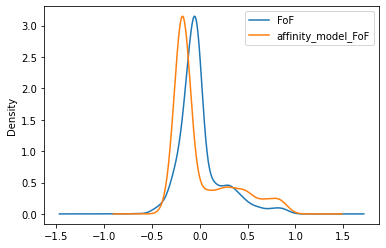

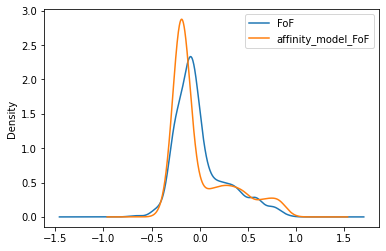

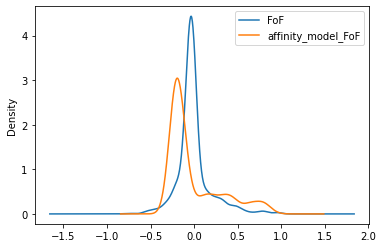

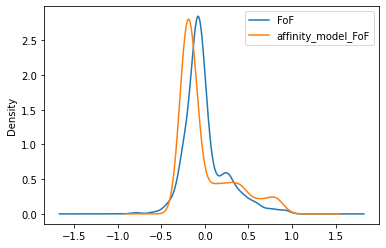

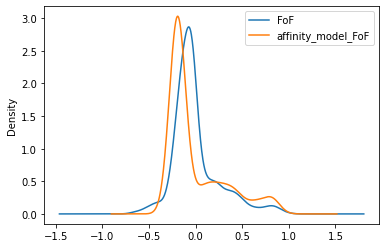

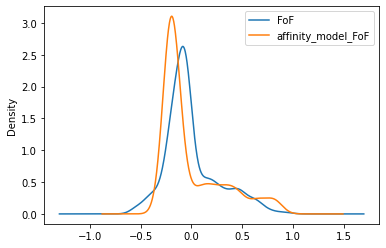

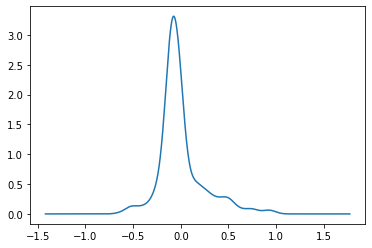

In [170]:
def plot_best_affinity_model(jury_or_tele, the_year, the_mu, the_sigma, the_alpha):
    best_affinity_model = AffinityModel(jury_or_televoting=jury_or_tele, year=the_year, mu=the_mu, sigma=the_sigma, alpha=the_alpha)

    best_affinity_model.step()
    best_affinity_model.df[["FoF", "affinity_model_FoF"]].plot.kde()

plot_best_affinity_model("T", 2016, 0.0, 0.0, 0.5)
plot_best_affinity_model("J", 2016, 0.1, 0.0, 0.5)

plot_best_affinity_model("T", 2017, 0.1, 0.0, 0.5)
plot_best_affinity_model("J", 2017, 0.1, 0.0, 0.25)

plot_best_affinity_model("T", 2018, 0.1, 0.0, 0.5)
plot_best_affinity_model("J", 2018, 0.0, 0.0, 0.5)

plot_best_affinity_model("T", 2019, 0.5, 0.0, 0.0)
plot_best_affinity_model("J", 2019, 0.0, 0.0, 0.5)

plot_best_affinity_model("T", 2021, -0.06, 0.0, 0.5)
plot_best_affinity_model("J", 2021, 0.1, 0.0, 0.5)

plot_best_affinity_model("T", 2022, 0.05, 0.0, 0.25)
plot_best_affinity_model("J", 2022, -0.1, 0.0, 0.25)

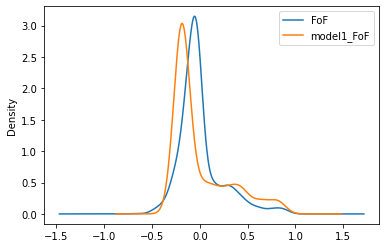

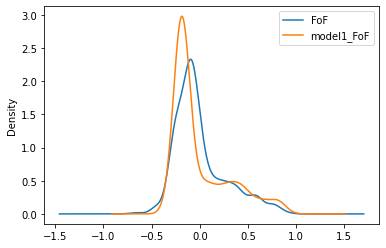

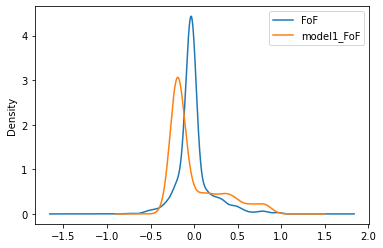

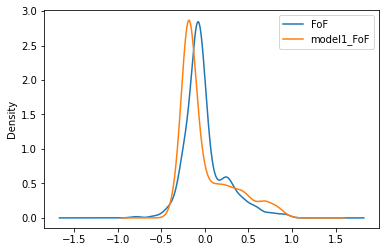

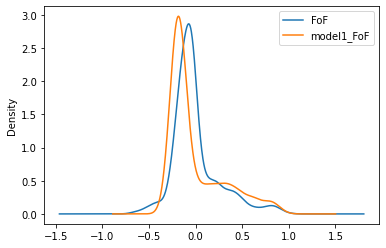

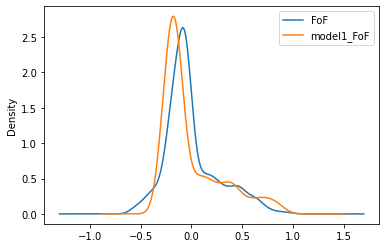

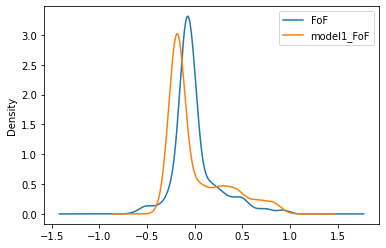

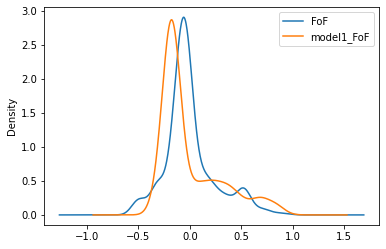

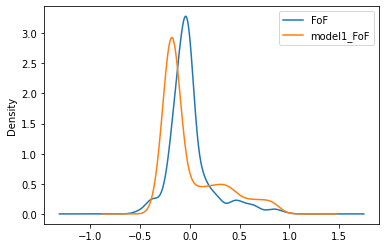

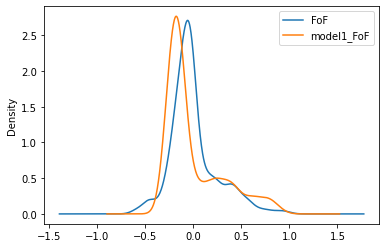

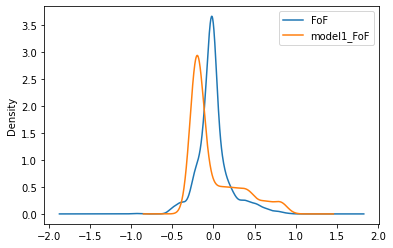

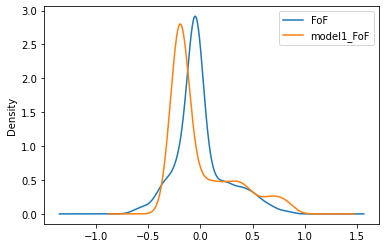

In [168]:
def plot_best_model1_model(jury_or_tele ,the_year):
    best_model1_model = Model1Model(jury_or_televoting=jury_or_tele, year=the_year)

    best_model1_model.step()
    best_model1_model.df[["FoF", "model1_FoF"]].plot.kde()

plot_best_model1_model("T", 2016)
plot_best_model1_model("J", 2016)

plot_best_model1_model("T", 2017)
plot_best_model1_model("J", 2017)

plot_best_model1_model("T", 2018)
plot_best_model1_model("J", 2018)

plot_best_model1_model("T", 2019)
plot_best_model1_model("J", 2019)

plot_best_model1_model("T", 2021)
plot_best_model1_model("J", 2021)

plot_best_model1_model("T", 2022)
plot_best_model1_model("J", 2022)

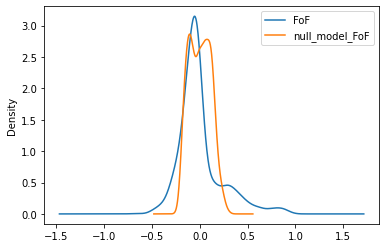

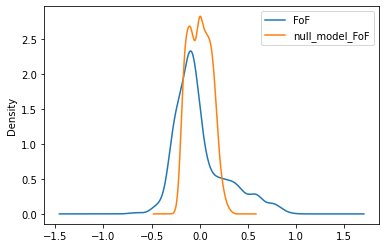

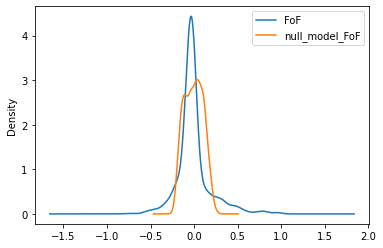

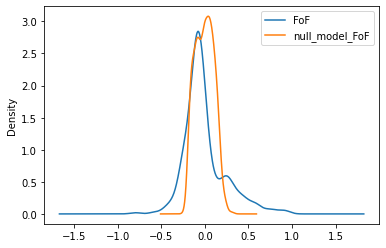

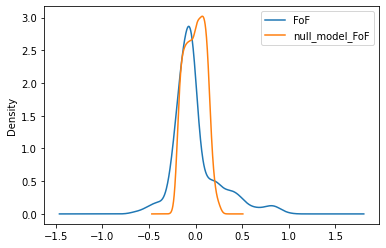

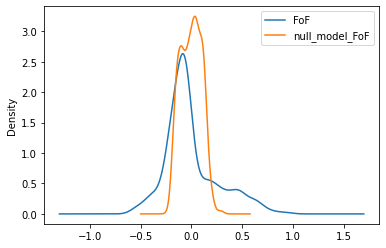

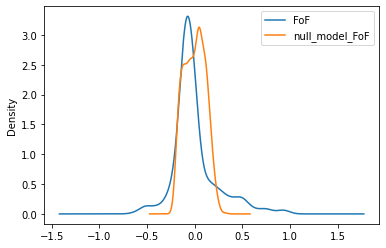

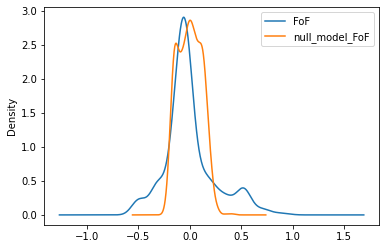

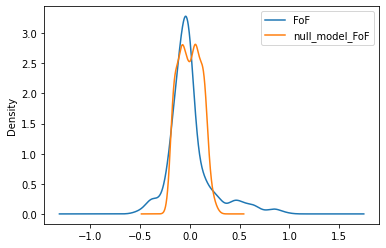

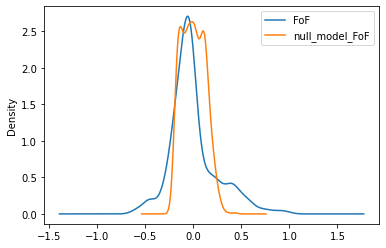

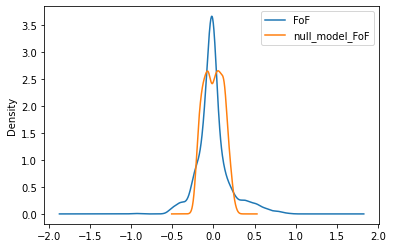

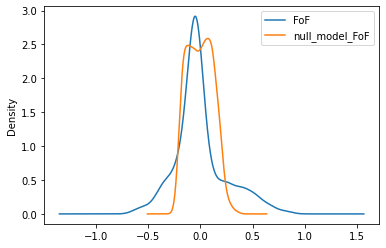

In [169]:
def plot_best_null_model(jury_or_tele, the_year):
    best_null_model = NullVotingModel(jury_or_televoting=jury_or_tele, year=the_year)

    best_null_model.step()
    best_null_model.df[["FoF", "null_model_FoF"]].plot.kde()

plot_best_null_model("T", 2016)
plot_best_null_model("J", 2016)

plot_best_null_model("T", 2017)
plot_best_null_model("J", 2017)

plot_best_null_model("T", 2018)
plot_best_null_model("J", 2018)

plot_best_null_model("T", 2019)
plot_best_null_model("J", 2019)

plot_best_null_model("T", 2021)
plot_best_null_model("J", 2021)

plot_best_null_model("T", 2022)
plot_best_null_model("J", 2022)